In [54]:
"""
Data exploration
"""
#Magic function: %matplotlib inline
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Set aesthetic parameters in one step
sns.set()

csv = '../datasets/Reviews.csv'
data = pd.read_csv(csv)

print("Head: ", data.columns)
print("row: ", data.shape[0], " col: ", data.shape[1])

Head:  Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
row:  568454  col:  10


Score          1         2        3         4         5
scores  0.091948  0.052368  0.07501  0.141885  0.638789
70& of total reviews is comprised of score 4 and 5


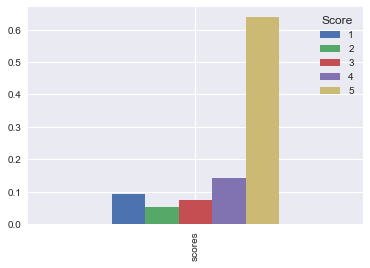

In [133]:
score_pct = np.bincount(data['Score']) / data.shape[0]

scores = pd.DataFrame(np.random.rand(1,5),
                     index=['scores'],
                     columns=pd.Index([1,2,3,4,5],
                                     name='Score'))

scores.iloc[0] = score_pct[1:]
scores.plot.bar()

print(scores)
print('70& of total reviews is comprised of score 4 and 5')



sentiment  negative  positive
count      0.223395  0.776605
78% of reviews is positive


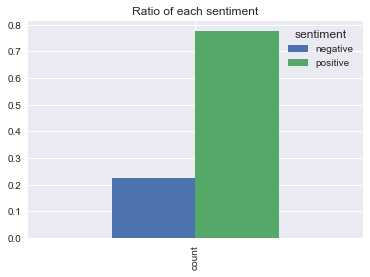

In [137]:
"""
Training classier and prediction
Categorized every review as either positive or negative, 
and will train a classifier to predict these two values.
"""

#We suffle the rows and extract an % of the rows
df_reduced = data.sample(frac=0.01, random_state=7)
reduced_data_size = df_reduced.shape[0]

#scores >= 4 positive, < negative 
reduced_labels = np.array([df_reduced['Score'] >= 4])[0][:].astype(int)
reduced_texts = df_reduced['Text'].values

#Percentage value of each sentiment 
reduced_sentiment_pct = np.bincount(reduced_labels) / reduced_data_size

sentiment = pd.DataFrame(np.random.rand(1,2),
                        index=['count'],
                        columns=pd.Index(["negative", "positive"],
                                        name='sentiment'))
sentiment.iloc[0] = reduced_sentiment_pct
sentiment.plot.bar(title="Ratio of each sentiment")

print(sentiment)
print('78% of reviews is positive')


In [139]:
#using 80% of data as training set and 20 as set test
train_size = int(reduced_data_size*0.8)

text_train = reduced_texts[:train_size]

y_train = reduced_labels[:train_size]

text_test = reduced_texts[train_size:]

y_test = reduced_labels[train_size:]